# Data

In [ ]:
# https://drive.google.com/file/d/1kc6XNqHZJg27KeBuoAoYj70_1rT92191/view?usp=sharing
!gdown --id 1kc6XNqHZJg27KeBuoAoYj70_1rT92191

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1kc6XNqHZJg27KeBuoAoYj70_1rT92191
From (redirected): https://drive.google.com/uc?id=1kc6XNqHZJg27KeBuoAoYj70_1rT92191&confirm=t&uuid=e5a5ebc6-7634-4477-97e5-6a76b9d3a300
To: /content/vqa_coco_dataset.zip
100% 196M/196M [00:01<00:00, 108MB/s]


In [ ]:
!unzip -q vqa_coco_dataset.zip

In [ ]:
!pip install timm -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.6 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torchtext
import os
import numpy as np
import pandas as pd
import spacy
import timm
import matplotlib.pyplot as plt
from tqdm import tqdm

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchvision import transforms
from transformers import ViTModel, ViTImageProcessor
from transformers import AutoTokenizer, RobertaModel

In [ ]:
with open('/content/vaq2.0.DevImages.txt', 'r') as f:
    lines = f.readlines()
lines[:1]

['COCO_val2014_000000262175.jpg#0\tIs this a designer tie ? no\n']

In [ ]:
def read_data_from_txt(file_path):
    data = []

    with open(file_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            temp = line.split('\t') # ['COCO_val2014_000000393225.jpg#0', 'Is this a creamy soup ? no\n']
            qa = temp[1].split('?') # ['Is this a creamy soup ', ' no\n']

            if len(qa) == 3:
                answer = qa[2].strip()
            else:
                answer = qa[1].strip()

            data_sample = {
                'image_path': temp[0][:-2],
                'question': qa[0] + '?',
                'answer': answer
            }
            data.append(data_sample)
    return data

In [ ]:
train_data = read_data_from_txt('./vaq2.0.TrainImages.txt')
val_data = read_data_from_txt('./vaq2.0.DevImages.txt')
test_data = read_data_from_txt('./vaq2.0.TestImages.txt')

In [ ]:
train_data[0]

{'image_path': 'COCO_val2014_000000393225.jpg',
 'question': 'Is this a creamy soup ?',
 'answer': 'no'}

In [ ]:
len(train_data), len(val_data), len(test_data)

(7846, 1952, 2022)

In [ ]:
example = 'hello, how are you today?'
tokenizer = get_tokenizer('basic_english')
tokenizer(example)

['hello', ',', 'how', 'are', 'you', 'today', '?']

In [ ]:
tokenizer = get_tokenizer('basic_english')

def yield_tokens(examples):
    for text in examples:
        question = text['question']
        yield tokenizer(question)

vocab = build_vocab_from_iterator(
    yield_tokens(train_data),
    min_freq=2,
    specials= ['<pad>', '<sos>', '<eos>', '<unk>'],
    special_first=True
)

vocab.set_default_index(vocab['<unk>'])

In [ ]:
vocab.get_stoi()['<unk>']

3

In [ ]:
vocab['?']

4

In [ ]:
len(vocab)

1671

In [ ]:
classes = set([sample['answer'] for sample in train_data])
classes_to_idx = {cls_name: idx for idx, cls_name in enumerate(classes)}
idx_to_classes = {idx: cls_name for idx, cls_name in enumerate(classes)}
print(idx_to_classes)

{0: 'yes', 1: 'no'}


In [ ]:
def tokenize(question, tokenizer, max_seq_len):
    input_ids = [vocab[token] for token in tokenizer(question)]

    if len(input_ids) < max_seq_len:
        input_ids += [vocab['<pad>']] * (max_seq_len - len(input_ids))
    else:
        input_ids = input_ids[:max_seq_len]

    return input_ids

In [ ]:
example_question = "Is this a picture of an apple?"
max_seq_len = 20

tokenize(example_question, tokenizer, max_seq_len)

[6, 5, 7, 16, 21, 75, 3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
class VQADataset(Dataset):
    def __init__(self, data, classes_to_idx, img_feature_extractor, text_tokenizer, device, root_dir='/content/val2014-resised/'):
        self.data = data
        self.root_dir = root_dir
        self.classes_to_idx = classes_to_idx
        self.img_feature_extractor = img_feature_extractor
        self.text_tokenizer = text_tokenizer
        self.device = device

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.data[index]['image_path'])
        img = Image.open(img_path).convert('RGB')

        if self.img_feature_extractor:
            img = self.img_feature_extractor(images=img, return_tensors="pt")
            img = {k: v.to(self.device).squeeze(0) for k, v in img.items()}

        question = self.data[index]['question']
        if self.text_tokenizer:
            question = self.text_tokenizer(
                question,
                padding="max_length",
                max_length=20,
                truncation=True,
                return_tensors="pt"
            )
            question = {k: v.to(self.device).squeeze(0) for k, v in question.items()}

        label = self.data[index]['answer']
        label = torch.tensor(
            classes_to_idx[label],
            dtype=torch.long
        ).to(device)

        sample = {
            'image': img,
            'question': question,
            'label': label
        }

        return sample # sample

In [ ]:
img_feature_extractor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224") # https://github.com/huggingface/transformers/blob/v4.35.2/src/transformers/models/vit/image_processing_vit.py#L41
text_tokenizer = AutoTokenizer.from_pretrained("roberta-base")
device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_dataset = VQADataset(
    train_data,
    classes_to_idx=classes_to_idx,
    img_feature_extractor=img_feature_extractor,
    text_tokenizer=text_tokenizer,
    device=device
)
val_dataset = VQADataset(
    val_data,
    classes_to_idx=classes_to_idx,
    img_feature_extractor=img_feature_extractor,
    text_tokenizer=text_tokenizer,
    device=device
)
test_dataset = VQADataset(
    test_data,
    classes_to_idx=classes_to_idx,
    img_feature_extractor=img_feature_extractor,
    text_tokenizer=text_tokenizer,
    device=device
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
train_dataset[0]

{'image': {'pixel_values': tensor([[[ 0.3882,  0.4431,  0.5137,  ..., -0.7804, -0.7725, -0.7725],
           [ 0.4118,  0.4275,  0.4824,  ..., -0.7725, -0.7725, -0.7725],
           [ 0.4510,  0.4275,  0.4745,  ..., -0.7647, -0.7647, -0.7647],
           ...,
           [-0.4980, -0.2392, -0.0196,  ...,  0.7255,  0.8118,  0.6706],
           [-0.0667, -0.0510,  0.0118,  ...,  0.6000,  0.6078,  0.6941],
           [-0.0196, -0.0039,  0.0039,  ...,  0.3725,  0.6627,  0.7725]],
  
          [[ 0.2157,  0.2706,  0.3098,  ..., -0.7020, -0.7098, -0.7098],
           [ 0.2392,  0.2549,  0.2941,  ..., -0.6941, -0.7098, -0.7098],
           [ 0.2784,  0.2549,  0.2863,  ..., -0.6863, -0.6863, -0.6863],
           ...,
           [-0.6078, -0.3333, -0.1216,  ...,  0.5451,  0.6157,  0.4588],
           [-0.1294, -0.1137, -0.0510,  ...,  0.3804,  0.4118,  0.5216],
           [-0.0510, -0.0353, -0.0588,  ...,  0.1137,  0.4824,  0.6314]],
  
          [[-0.1059, -0.0353,  0.0510,  ..., -0.6941, -0.69

In [ ]:
# index = 10
# image = train_dataset[index][0].numpy().transpose((1, 2, 0))
# question =  ' '.join([vocab.lookup_token(token) for token in train_dataset[index][1]])
# answer = idx_to_classes[train_dataset[index][2].item()]

# plt.imshow(image)

# plt.show()
# print(question)
# print(answer)

In [ ]:
train_batch_size = 256
test_batch_size = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False
)
test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

In [ ]:
next(iter(train_loader))

{'image': {'pixel_values': tensor([[[[-0.2627, -0.2627, -0.2784,  ...,  0.2314,  0.2314,  0.2235],
            [-0.2627, -0.2627, -0.2784,  ...,  0.2392,  0.2314,  0.2314],
            [-0.2549, -0.2549, -0.2706,  ...,  0.2392,  0.2314,  0.2314],
            ...,
            [ 0.0510, -0.0118,  0.0980,  ..., -0.1451, -0.0824,  0.0588],
            [-0.0431, -0.0275,  0.0745,  ..., -0.1216, -0.1765, -0.0667],
            [-0.0431, -0.0196, -0.0196,  ...,  0.0902, -0.1529, -0.1922]],
  
           [[ 0.0275,  0.0275,  0.0431,  ...,  0.4980,  0.4980,  0.4902],
            [ 0.0275,  0.0275,  0.0431,  ...,  0.5059,  0.4980,  0.4980],
            [ 0.0196,  0.0431,  0.0510,  ...,  0.5059,  0.4980,  0.4980],
            ...,
            [-0.0510, -0.1137, -0.0039,  ..., -0.1843, -0.1216,  0.0196],
            [-0.1529, -0.1373, -0.0275,  ..., -0.1608, -0.2157, -0.1059],
            [-0.1529, -0.1294, -0.1216,  ...,  0.0510, -0.1922, -0.2314]],
  
           [[ 0.4588,  0.4353,  0.3882,  ...,

# Models

In [ ]:
class VisualEncoder(nn.Module):
    def __init__(self):
        super(VisualEncoder, self).__init__()
        self.model = ViTModel.from_pretrained("google/vit-base-patch16-224")

    def forward(self, inputs):
        outputs = self.model(**inputs) # [256, 197, 768]

        return outputs.pooler_output

class TextEncoder(nn.Module):
    def __init__(self):
        super(TextEncoder, self).__init__()
        self.model = RobertaModel.from_pretrained("roberta-base")

    def forward(self, inputs):
        outputs = self.model(**inputs)

        return outputs.pooler_output

class Classifier(nn.Module):
    def __init__(self, input_size=768*2, hidden_size=512, n_layers=1, dropout_prob=0.2, n_classes=2):
        super(Classifier,self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=n_layers, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc1 = nn.Linear(hidden_size*2, n_classes)

    def forward(self,x):
        x, _ = self.lstm(x)
        x = self.dropout(x)
        x = self.fc1(x)
        return x

In [ ]:
class VQAModel(nn.Module):
    def __init__(self, hidden_size=512, n_layers=1, dropout_prob=0.2, n_classes=2):
        super(VQAModel, self).__init__()
        self.visual_encoder = VisualEncoder().to(device)
        self.text_encoder = TextEncoder().to(device)
        self.classifier = Classifier(
            hidden_size=hidden_size,
            n_layers=n_layers,
            dropout_prob=dropout_prob,
            n_classes=n_classes
        ).to(device)


    def forward(self, image, question):
        image_out = self.visual_encoder(image) # [256, 768]
        text_out = self.text_encoder(question)
        x = torch.cat((text_out, image_out), dim=1)
        x = self.classifier(x)
        return x

    def freeze(self, visual=True, textual=True, clas=False):
        if visual:
            for n,p in self.visual_encoder.named_parameters():
                p.requires_grad = False
        if textual:
            for n,p in self.text_encoder.named_parameters():
                p.requires_grad = False
        if clas:
            for n,p in self.classifier.named_parameters():
                p.requires_grad = False

In [ ]:
n_classes = len(classes)
hidden_size = 1024
n_layers = 1
dropout_prob = 0.2

model = VQAModel(
    hidden_size=hidden_size,
    n_layers=n_layers,
    dropout_prob=dropout_prob,
    n_classes=n_classes
).to(device)
model.freeze()

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
inputs = next(iter(train_loader))

model.eval()
with torch.no_grad():
    image = inputs['image']
    question = inputs['question']
    output = model(image, question)
    print(output.shape)

torch.Size([256, 2])


In [ ]:
def evaluate(model, dataloader, criterion):
    model.eval()
    correct = 0
    total = 0
    losses = []
    with torch.no_grad():
        for index, inputs in enumerate(dataloader):
            images = inputs['image']
            questions = inputs['question']
            labels = inputs['label']

            outputs = model(images, questions)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = sum(losses) / len(losses)
    acc = correct / total

    return loss, acc

In [ ]:
def fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    epochs,
):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        batch_train_losses = []

        with tqdm(total=len(train_loader), desc=f"Epoch {epoch + 1}") as pbar:
            model.train()
            for idx, inputs in enumerate(train_loader):
                images = inputs['image']
                questions = inputs['question']
                labels = inputs['label']

                optimizer.zero_grad()
                outputs = model(images, questions)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                batch_train_losses.append(loss.item())
                pbar.update(1)  # Update the progress bar

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        val_loss, val_acc = evaluate(model, val_loader, criterion)
        val_losses.append(val_loss)

        print(
            f'EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}\tVal Acc: {val_acc}'
        )

        scheduler.step()

    return train_losses, val_losses

In [ ]:
lr = 1e-2
epochs = 50
scheduler_step_size = epochs * 0.6
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(),lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=scheduler_step_size,
)

 # Training

In [ ]:
train_losses, val_losses = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    epochs
)

Epoch 1: 100%|██████████| 31/31 [03:24<00:00,  6.58s/it]


EPOCH 1:	Train loss: 1.6848	Val loss: 0.7135	Val Acc: 0.4641393442622951


Epoch 2: 100%|██████████| 31/31 [03:12<00:00,  6.20s/it]


EPOCH 2:	Train loss: 0.7040	Val loss: 0.6903	Val Acc: 0.5368852459016393


Epoch 3: 100%|██████████| 31/31 [03:10<00:00,  6.14s/it]


EPOCH 3:	Train loss: 0.6927	Val loss: 0.6883	Val Acc: 0.5389344262295082


Epoch 4: 100%|██████████| 31/31 [03:10<00:00,  6.16s/it]


EPOCH 4:	Train loss: 0.6804	Val loss: 0.6776	Val Acc: 0.5778688524590164


Epoch 5: 100%|██████████| 31/31 [03:29<00:00,  6.75s/it]


EPOCH 5:	Train loss: 0.6791	Val loss: 0.6758	Val Acc: 0.5891393442622951


Epoch 6: 100%|██████████| 31/31 [03:20<00:00,  6.45s/it]


EPOCH 6:	Train loss: 0.6636	Val loss: 0.6799	Val Acc: 0.5701844262295082


Epoch 7: 100%|██████████| 31/31 [03:13<00:00,  6.24s/it]


EPOCH 7:	Train loss: 0.6624	Val loss: 0.6733	Val Acc: 0.579405737704918


Epoch 8: 100%|██████████| 31/31 [03:13<00:00,  6.23s/it]


EPOCH 8:	Train loss: 0.6563	Val loss: 0.6770	Val Acc: 0.5819672131147541


Epoch 9: 100%|██████████| 31/31 [03:12<00:00,  6.20s/it]


EPOCH 9:	Train loss: 0.6454	Val loss: 0.6624	Val Acc: 0.6137295081967213


Epoch 10: 100%|██████████| 31/31 [03:12<00:00,  6.20s/it]


EPOCH 10:	Train loss: 0.6336	Val loss: 0.6647	Val Acc: 0.6029713114754098


Epoch 11: 100%|██████████| 31/31 [03:13<00:00,  6.26s/it]


EPOCH 11:	Train loss: 0.6340	Val loss: 0.6647	Val Acc: 0.6132172131147541


Epoch 12: 100%|██████████| 31/31 [03:13<00:00,  6.26s/it]


EPOCH 12:	Train loss: 0.6137	Val loss: 0.6601	Val Acc: 0.6075819672131147


Epoch 13: 100%|██████████| 31/31 [03:16<00:00,  6.34s/it]


EPOCH 13:	Train loss: 0.6019	Val loss: 0.6469	Val Acc: 0.6357581967213115


Epoch 14: 100%|██████████| 31/31 [03:14<00:00,  6.29s/it]


EPOCH 14:	Train loss: 0.5953	Val loss: 0.6546	Val Acc: 0.6229508196721312


Epoch 15: 100%|██████████| 31/31 [03:10<00:00,  6.16s/it]


EPOCH 15:	Train loss: 0.5899	Val loss: 0.6391	Val Acc: 0.6413934426229508


Epoch 16: 100%|██████████| 31/31 [03:12<00:00,  6.20s/it]


EPOCH 16:	Train loss: 0.5578	Val loss: 0.6335	Val Acc: 0.6470286885245902


Epoch 17: 100%|██████████| 31/31 [03:12<00:00,  6.20s/it]


EPOCH 17:	Train loss: 0.5582	Val loss: 0.6288	Val Acc: 0.6501024590163934


Epoch 18: 100%|██████████| 31/31 [03:11<00:00,  6.18s/it]


EPOCH 18:	Train loss: 0.5510	Val loss: 0.6231	Val Acc: 0.6588114754098361


Epoch 19: 100%|██████████| 31/31 [03:25<00:00,  6.62s/it]


EPOCH 19:	Train loss: 0.5270	Val loss: 0.6216	Val Acc: 0.6654713114754098


Epoch 20: 100%|██████████| 31/31 [03:22<00:00,  6.53s/it]


EPOCH 20:	Train loss: 0.5255	Val loss: 0.6280	Val Acc: 0.6582991803278688


Epoch 21:  16%|█▌        | 5/31 [00:30<02:36,  6.02s/it]

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(train_losses)
ax[0].set_title('Training Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].plot(val_losses, color='orange')
ax[1].set_title('Val Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
plt.show()

In [ ]:
val_loss, val_acc = evaluate(
    model,
    val_loader,
    criterion
)
test_loss, test_acc = evaluate(
    model,
    test_loader,
    criterion
)

print('Evaluation on val/test dataset')
print('Val accuracy: ', val_acc)
print('Test accuracy: ', test_acc)

In [ ]:
train_losses, val_losses = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    epochs
)

Epoch 1: 100%|██████████| 31/31 [03:08<00:00,  6.07s/it]


EPOCH 1:	Train loss: 1.6768	Val loss: 0.7996	Val Acc: 0.4641393442622951


Epoch 2: 100%|██████████| 31/31 [03:04<00:00,  5.96s/it]


EPOCH 2:	Train loss: 0.7315	Val loss: 0.7123	Val Acc: 0.4641393442622951


Epoch 3: 100%|██████████| 31/31 [03:09<00:00,  6.10s/it]


EPOCH 3:	Train loss: 0.7076	Val loss: 0.7011	Val Acc: 0.5358606557377049


Epoch 4: 100%|██████████| 31/31 [03:12<00:00,  6.20s/it]


EPOCH 4:	Train loss: 0.7176	Val loss: 0.7257	Val Acc: 0.4641393442622951


Epoch 5: 100%|██████████| 31/31 [03:16<00:00,  6.33s/it]


EPOCH 5:	Train loss: 0.7215	Val loss: 0.7058	Val Acc: 0.4723360655737705


Epoch 6: 100%|██████████| 31/31 [03:16<00:00,  6.34s/it]


EPOCH 6:	Train loss: 0.7167	Val loss: 0.6807	Val Acc: 0.5676229508196722


Epoch 7: 100%|██████████| 31/31 [03:14<00:00,  6.26s/it]


EPOCH 7:	Train loss: 0.7020	Val loss: 0.6862	Val Acc: 0.5578893442622951


Epoch 8: 100%|██████████| 31/31 [03:13<00:00,  6.23s/it]


EPOCH 8:	Train loss: 0.6850	Val loss: 0.7065	Val Acc: 0.5061475409836066


Epoch 9: 100%|██████████| 31/31 [03:12<00:00,  6.22s/it]


EPOCH 9:	Train loss: 0.7219	Val loss: 0.6783	Val Acc: 0.5753073770491803


Epoch 10: 100%|██████████| 31/31 [03:13<00:00,  6.23s/it]


EPOCH 10:	Train loss: 0.6838	Val loss: 0.7285	Val Acc: 0.5010245901639344


Epoch 11: 100%|██████████| 31/31 [03:14<00:00,  6.27s/it]


EPOCH 11:	Train loss: 0.7046	Val loss: 0.7828	Val Acc: 0.48514344262295084


Epoch 12: 100%|██████████| 31/31 [03:12<00:00,  6.20s/it]


EPOCH 12:	Train loss: 0.7298	Val loss: 0.7745	Val Acc: 0.48770491803278687


Epoch 13: 100%|██████████| 31/31 [03:14<00:00,  6.27s/it]


EPOCH 13:	Train loss: 0.6686	Val loss: 0.6694	Val Acc: 0.5896516393442623


Epoch 14: 100%|██████████| 31/31 [03:12<00:00,  6.21s/it]


EPOCH 14:	Train loss: 0.6642	Val loss: 0.7018	Val Acc: 0.545594262295082


Epoch 15: 100%|██████████| 31/31 [03:12<00:00,  6.19s/it]


EPOCH 15:	Train loss: 0.6655	Val loss: 0.6648	Val Acc: 0.6004098360655737


Epoch 16: 100%|██████████| 31/31 [03:11<00:00,  6.17s/it]


EPOCH 16:	Train loss: 0.6559	Val loss: 0.6792	Val Acc: 0.586577868852459


Epoch 17: 100%|██████████| 31/31 [03:11<00:00,  6.17s/it]


EPOCH 17:	Train loss: 0.6521	Val loss: 0.8753	Val Acc: 0.4769467213114754


Epoch 18: 100%|██████████| 31/31 [03:11<00:00,  6.19s/it]


EPOCH 18:	Train loss: 0.7023	Val loss: 0.6726	Val Acc: 0.5809426229508197


Epoch 19: 100%|██████████| 31/31 [03:12<00:00,  6.20s/it]


EPOCH 19:	Train loss: 0.6492	Val loss: 0.6944	Val Acc: 0.5681352459016393


Epoch 20: 100%|██████████| 31/31 [03:11<00:00,  6.18s/it]


EPOCH 20:	Train loss: 0.6321	Val loss: 0.7194	Val Acc: 0.5783811475409836


Epoch 21: 100%|██████████| 31/31 [03:11<00:00,  6.19s/it]


EPOCH 21:	Train loss: 0.6671	Val loss: 0.6808	Val Acc: 0.5819672131147541


Epoch 22: 100%|██████████| 31/31 [03:11<00:00,  6.17s/it]


EPOCH 22:	Train loss: 0.6165	Val loss: 0.6586	Val Acc: 0.6091188524590164


Epoch 23: 100%|██████████| 31/31 [03:12<00:00,  6.21s/it]


EPOCH 23:	Train loss: 0.6224	Val loss: 0.6538	Val Acc: 0.6091188524590164


Epoch 24: 100%|██████████| 31/31 [03:12<00:00,  6.21s/it]


EPOCH 24:	Train loss: 0.6179	Val loss: 0.6585	Val Acc: 0.6111680327868853


Epoch 25: 100%|██████████| 31/31 [03:12<00:00,  6.22s/it]


EPOCH 25:	Train loss: 0.5773	Val loss: 0.6524	Val Acc: 0.6183401639344263


Epoch 26: 100%|██████████| 31/31 [03:13<00:00,  6.23s/it]


EPOCH 26:	Train loss: 0.5662	Val loss: 0.6500	Val Acc: 0.617827868852459


Epoch 27: 100%|██████████| 31/31 [03:12<00:00,  6.20s/it]


EPOCH 27:	Train loss: 0.5657	Val loss: 0.6502	Val Acc: 0.6152663934426229


Epoch 28: 100%|██████████| 31/31 [03:12<00:00,  6.23s/it]


EPOCH 28:	Train loss: 0.5585	Val loss: 0.6498	Val Acc: 0.6157786885245902


Epoch 29: 100%|██████████| 31/31 [03:12<00:00,  6.22s/it]


EPOCH 29:	Train loss: 0.5568	Val loss: 0.6448	Val Acc: 0.6239754098360656


Epoch 30: 100%|██████████| 31/31 [03:16<00:00,  6.33s/it]


EPOCH 30:	Train loss: 0.5531	Val loss: 0.6455	Val Acc: 0.6265368852459017


Epoch 31: 100%|██████████| 31/31 [03:12<00:00,  6.22s/it]


EPOCH 31:	Train loss: 0.5488	Val loss: 0.6491	Val Acc: 0.6224385245901639


Epoch 32: 100%|██████████| 31/31 [03:13<00:00,  6.26s/it]


EPOCH 32:	Train loss: 0.5523	Val loss: 0.6483	Val Acc: 0.617827868852459


Epoch 33: 100%|██████████| 31/31 [03:31<00:00,  6.81s/it]


EPOCH 33:	Train loss: 0.5446	Val loss: 0.6431	Val Acc: 0.6229508196721312


Epoch 34: 100%|██████████| 31/31 [03:14<00:00,  6.28s/it]


EPOCH 34:	Train loss: 0.5427	Val loss: 0.6449	Val Acc: 0.6331967213114754


Epoch 35: 100%|██████████| 31/31 [03:17<00:00,  6.36s/it]


EPOCH 35:	Train loss: 0.5463	Val loss: 0.6411	Val Acc: 0.6296106557377049


Epoch 36: 100%|██████████| 31/31 [03:19<00:00,  6.43s/it]


EPOCH 36:	Train loss: 0.5361	Val loss: 0.6457	Val Acc: 0.6347336065573771


Epoch 37: 100%|██████████| 31/31 [03:15<00:00,  6.29s/it]


EPOCH 37:	Train loss: 0.5366	Val loss: 0.6420	Val Acc: 0.6316598360655737


Epoch 38: 100%|██████████| 31/31 [03:11<00:00,  6.18s/it]


EPOCH 38:	Train loss: 0.5374	Val loss: 0.6441	Val Acc: 0.6214139344262295


Epoch 39: 100%|██████████| 31/31 [03:13<00:00,  6.25s/it]


EPOCH 39:	Train loss: 0.5372	Val loss: 0.6389	Val Acc: 0.6331967213114754


Epoch 40: 100%|██████████| 31/31 [03:12<00:00,  6.21s/it]


EPOCH 40:	Train loss: 0.5331	Val loss: 0.6405	Val Acc: 0.6357581967213115


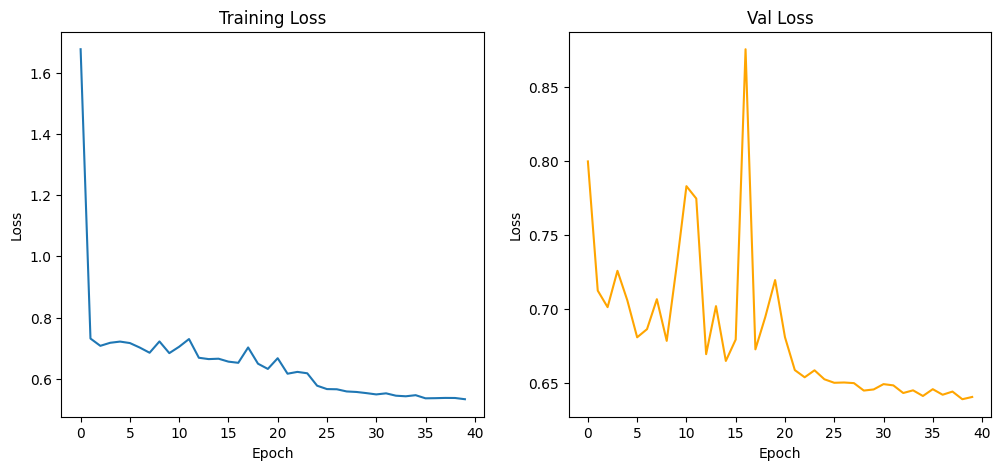

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(train_losses)
ax[0].set_title('Training Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].plot(val_losses, color='orange')
ax[1].set_title('Val Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
plt.show()

In [ ]:
val_loss, val_acc = evaluate(
    model,
    val_loader,
    criterion
)
test_loss, test_acc = evaluate(
    model,
    test_loader,
    criterion
)

print('Evaluation on val/test dataset')
print('Val accuracy: ', val_acc)
print('Test accuracy: ', test_acc)

Evaluation on val/test dataset
Val accuracy:  0.6357581967213115
Test accuracy:  0.6221562809099901


In [ ]:
torch.save(model.state_dict(), "vqa_weights.pth")

In [ ]:
import shutil
shutil.move('/content/vqa_weights.pth', '/content/drive/MyDrive')

'/content/drive/MyDrive/vqa_weights.pth'

In [ ]:
!gdown --id 1hyRAuIT9XkxaP86seY94yjfKfKlINrWE

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1hyRAuIT9XkxaP86seY94yjfKfKlINrWE
From (redirected): https://drive.google.com/uc?id=1hyRAuIT9XkxaP86seY94yjfKfKlINrWE&confirm=t&uuid=514ebc4c-15eb-4dd5-8555-cd50d6e2a226
To: /content/vqa_weights.pth
100% 928M/928M [00:13<00:00, 70.4MB/s]
